## Section 0: Importing Necessary Packages

In [1]:
# importing necessary packages (standard for data cleaning and plotting)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

# importing sklearn packages, important for modeling
import sklearn.datasets as datasets
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import export_graphviz
from sklearn.metrics import mean_squared_error, confusion_matrix   
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

# importing packages used to help with class imbalance
import imblearn
from imblearn.over_sampling import SMOTE, ADASYN 

#options
pd.options.mode.chained_assignment = None
pd.set_option('display.max_colwidth', 100)
pd.options.display.max_rows = 50
import warnings
warnings.filterwarnings('ignore') 

## Section 1: Exploratory Analysis

#### Importing data from data folder in library

In [2]:
# reading in necessary csv files
games_details = pd.read_csv('data/games_details.csv')
games = pd.read_csv("data/games.csv",parse_dates=["GAME_DATE_EST"],infer_datetime_format=True)
# parsing our dates and putting them into datetime format
games = games.drop_duplicates().sort_values("GAME_DATE_EST").set_index(["GAME_DATE_EST"])
# dropping any duplicate dates, and sorting values so that earliest date comes first. setting the date as our index
ranking = pd.read_csv("data/ranking.csv",parse_dates=["STANDINGSDATE"])
ranking.sort_values("STANDINGSDATE", inplace=True)
players = pd.read_csv('data/players.csv')
teams = pd.read_csv('data/teams.csv')
pd.options.display.max_columns = 50
# making it so that we can see up to 50 columns every time we look at our data

#### Understanding Each Dataset

In [4]:
games_details.head(2)
# observing our game details dataset

,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,START_POSITION,COMMENT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS
0,12000047,1610612766,CHA,Charlotte,1628998,Cody Martin,F,NaN,17:06,0.0,2.0,0.000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,1.0,0.0,1.0,1.0,2.0,0.0,-31.0
1,12000047,1610612766,CHA,Charlotte,1629023,P.J. Washington,F,NaN,24:58,4.0,17.0,0.235,0.0,3.0,0.0,1.0,2.0,0.5,1.0,6.0,7.0,2.0,2.0,1.0,5.0,3.0,9.0,-2.0


In [5]:
games.head(2)
# observing our games dataset

,GAME_ID,GAME_STATUS_TEXT,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
GAME_DATE_EST,,,,,,,,,,,,,,,,,,,,
2003-10-05,10300001,Final,1610612762,1610612742,2003,1610612762,90.0,0.457,0.735,0.143,23.0,41.0,1610612742,85.0,0.447,0.5,0.250,20.0,38.0,1
2003-10-06,10300002,Final,1610612763,1610612749,2003,1610612763,105.0,0.494,0.618,0.267,25.0,48.0,1610612749,94.0,0.427,0.7,0.154,20.0,43.0,1


In [6]:
players.head(2)
# observing our players dataset

,PLAYER_NAME,TEAM_ID,PLAYER_ID,SEASON
0,Royce O'Neale,1610612762,1626220,2019
1,Bojan Bogdanovic,1610612762,202711,2019


In [7]:
ranking.head(2)
# observing our ranking dataset

,TEAM_ID,LEAGUE_ID,SEASON_ID,STANDINGSDATE,CONFERENCE,TEAM,G,W,L,W_PCT,HOME_RECORD,ROAD_RECORD,RETURNTOPLAY
159591,1610612752,0,22002,2003-10-01,East,New York,82,37,45,0.451,24-17,13-28,NaN
159583,1610612765,0,22002,2003-10-01,East,Detroit,82,50,32,0.610,30-11,20-21,NaN


In [8]:
teams.head(2)
# observing our team dataset

,LEAGUE_ID,TEAM_ID,MIN_YEAR,MAX_YEAR,ABBREVIATION,NICKNAME,YEARFOUNDED,CITY,ARENA,ARENACAPACITY,OWNER,GENERALMANAGER,HEADCOACH,DLEAGUEAFFILIATION
0,0,1610612737,1949,2019,ATL,Hawks,1949,Atlanta,State Farm Arena,18729.0,Tony Ressler,Travis Schlenk,Lloyd Pierce,Erie Bayhawks
1,0,1610612738,1946,2019,BOS,Celtics,1946,Boston,TD Garden,18624.0,Wyc Grousbeck,Danny Ainge,Brad Stevens,Maine Red Claws


#### Looking at what variables are highly correlated for Multicollinearity. Threshold is at 0.8.


In [9]:
# creating a correlation matrix in order to see which variables are highly correlated with one another.
corr_matrix = games.corr().abs()
corr_matrix2 = games.corr()

# the matrix is symmetric so we need to extract upper triangle matrix without diagonal (k = 1)

sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                  .stack()
                  .sort_values(ascending=False))

sol2 = (corr_matrix2.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                  .stack()
                  .sort_values(ascending=False))

corr_matrix.head(3)

,GAME_ID,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
GAME_ID,1.000000,0.026462,0.032588,0.085846,0.026462,0.024514,0.016698,0.033897,0.004990,0.037499,0.008273,0.032588,0.007666,0.001855,0.031238,0.005855,0.047710,0.027572,0.034022
HOME_TEAM_ID,0.026462,1.000000,0.046723,0.001295,1.000000,0.025925,0.002933,0.005436,0.006255,0.103919,0.032364,0.046723,0.012620,0.024044,0.020054,0.015537,0.078197,0.039335,0.019983
VISITOR_TEAM_ID,0.032588,0.046723,1.000000,0.002648,0.046723,0.007574,0.034006,0.006829,0.017595,0.015561,0.013453,1.000000,0.039336,0.024353,0.017947,0.024362,0.014975,0.011753,0.032007


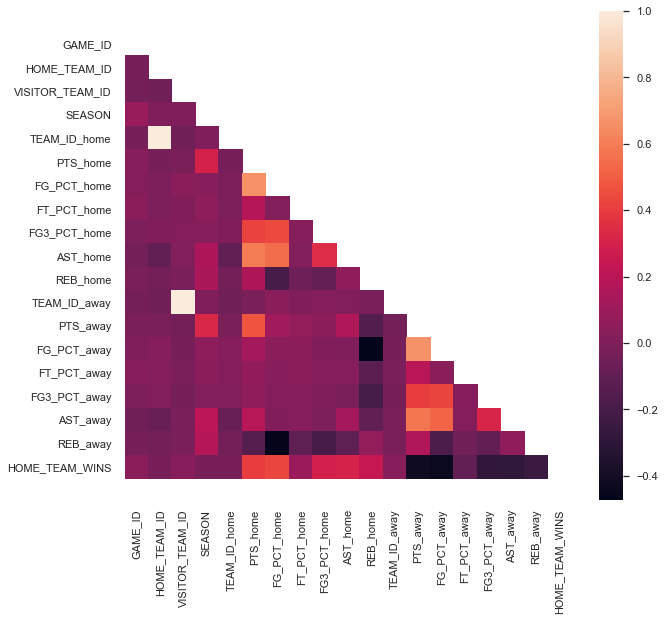

In [10]:
# creating a heatmap of the correlation matrix, to show which variables are highly correlated visually
plt.style.use('seaborn')
sns.set(style="white") 
f, ax = plt.subplots(figsize=(10, 9))
mask = np.zeros_like(games.corr())
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(games.corr(), mask=mask, square=True)
b, t = plt.ylim() 
b += .75
t -= .75 
plt.ylim(b, t) 
plt.show()

In [11]:
print('Home Team Average Points: ', games.PTS_home.mean())
print('Away Team Average Points: ', games.PTS_away.mean())

Home Team Average Points:  102.28342086161992
Away Team Average Points:  99.33657828444558


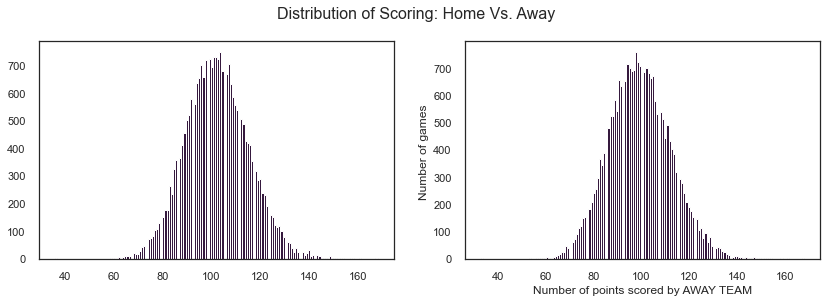

mean: 102.28342086161992 std: 12.949816023318826
mean: 99.33657828444558 std: 13.018652892876455


In [12]:
# side-by-side distribution of scoring for both the home team and away teams
sns.set_palette("rocket")

fig, axes = plt.subplots(1, 2, figsize = (14,4))

axes[0].hist(games["PTS_home"],bins = int(np.sqrt(len(games["PTS_home"]))))
plt.xlabel("Number of points scored by HOME TEAM")
plt.ylabel("Number of games ")
mean_ptsh = np.mean(games["PTS_home"])
std_ptsh=np.std(games["PTS_home"])

axes[1].hist(games["PTS_away"],bins = int(np.sqrt(len(games["PTS_away"]))))
plt.xlabel("Number of points scored by AWAY TEAM")
plt.ylabel("Number of games ")
mean_ptsa = np.mean(games["PTS_away"])
std_ptsa=np.std(games["PTS_away"])
plt.suptitle("Distribution of Scoring: Home Vs. Away", size=16, y=1)
plt.show()
print ("mean:",mean_ptsh,"std:",std_ptsh)
print ("mean:",mean_ptsa,"std:",std_ptsa)

##### As you can see, home team on average scores more points than the away team, by roughly 3 points (an indicator of home-team advantage, although small).

In [13]:
# here, we take a look at value counts of our dependent variable. as you can see, we have a class imbalance of roughly 60-40%. this gives us an indication that we may want to resample.
games.HOME_TEAM_WINS.value_counts()

1    13901
0     9619
Name: HOME_TEAM_WINS, dtype: int64

##### Another big indicator that the home team has a large advantage over the away team. Home team wins roughly 59% of the time to the away teams 41%. On any given day, all else equal, the home team is more likely to win than the away team. This also shows the class imbalance of our depedent vairable. 

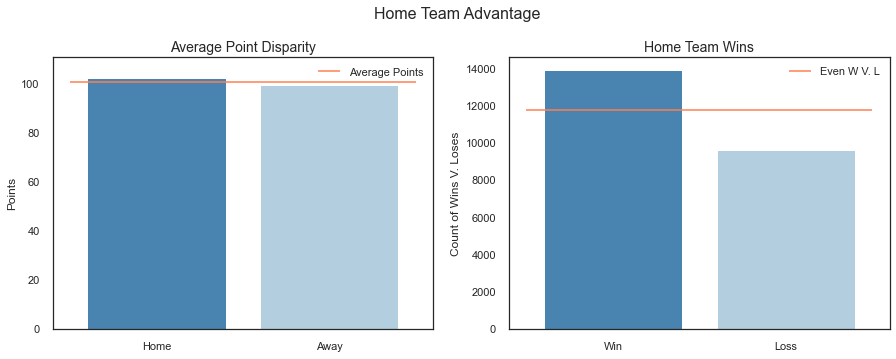

In [14]:
# show that home teams score more on average than away teams
home_team = games.PTS_home.mean()
away_team = games.PTS_away.mean()
points = (home_team+away_team)/2

#prepare plot labels
label_team= ["Home", "Away"]
values_team = [home_team, away_team]

#--------------------------Bar Plots--------------------------------------#
fig, ax = plt.subplots(1, 2, figsize=(15,5))

# because I want to do side-by-side graphs, I create to axes.
sns.barplot(ax = ax[0], x=label_team, y=values_team, palette="Blues_r")
sns.barplot(ax = ax[1], x=games.HOME_TEAM_WINS.value_counts().index, y=games.HOME_TEAM_WINS.value_counts(), order = [1,0], palette="Blues_r")
ax[0].hlines(points, -.5 ,1.5, colors="coral", label="Average Points") #plot average price horizontal line
ax[1].hlines(len(games)/2, -.5 ,1.5, colors="coral", label="Even W V. L") #plot average price horizontal line

#prettify graphs
ax[0].set_ylabel("Points", size=12)
ax[0].set_title("Average Point Disparity", size=14)
ax[0].set_ylim(0,1.1*points)
ax[0].legend()

ax[1].set_ylabel("Count of Wins V. Loses", size=12)
ax[1].set_title("Home Team Wins", size=14)
ax[1].set_xticklabels(['Win', 'Loss'])
# ax[1].set_ylim(0,1.1*)
ax[1].legend()

plt.suptitle("Home Team Advantage", size=16, y=1.02)
plt.show()

##### Here is a good graph showing side-by-side the difference in home team and away team points, and the disparity between home team wins and losses. Although the point differential is relatively small, we can also see that that home team wins a lot more than they lose, which shows that being at home gives a team a huge advantage.

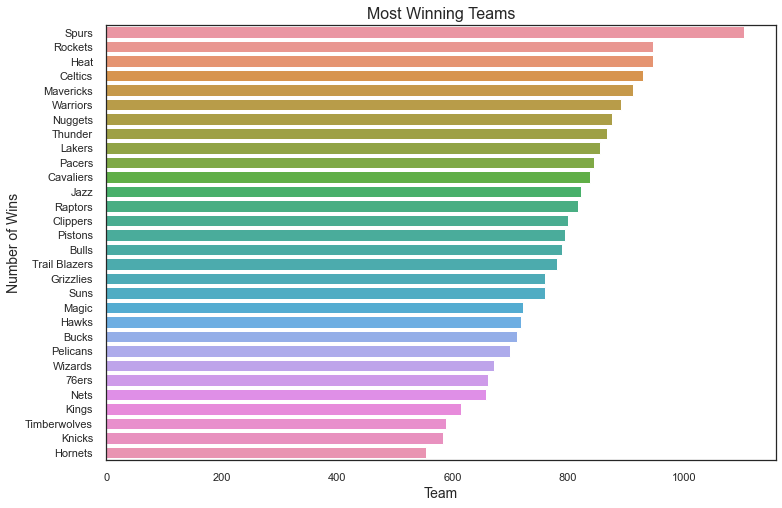

In [15]:
# here, I created a graph showing the most winning teams over our entire dataset. this should be normally distributed (i.e. if everything was fair each team would have roughly the same amount of wins), but this is 
# not the case and shows that franchises operate differently
winning_teams = np.where(games['HOME_TEAM_WINS'] == 1, games['HOME_TEAM_ID'], games['VISITOR_TEAM_ID'])
winning_teams = pd.DataFrame(winning_teams, columns=['TEAM_ID'])
winning_teams = winning_teams.merge(teams[['TEAM_ID', 'NICKNAME']], on='TEAM_ID')['NICKNAME'].value_counts().to_frame().reset_index()
winning_teams.columns = ['TEAM NAME', 'Number of wins']

fig, ax = plt.subplots(figsize=(12, 8)) 
sns.barplot(winning_teams['Number of wins'], winning_teams['TEAM NAME'])

ax.set_title("Most Winning Teams", size=16)
ax.set_xlabel("Team", size=14)
ax.set_ylabel("Number of Wins", size=14)

plt.show()

##### Some teams or franchises seem to win more than others (i.e. the spurs compared to the hornets). This could be due to a number of factors (coach, when the team was founded, location of team, ownership, etc.). 

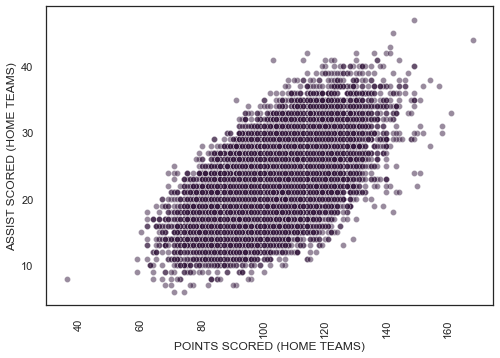

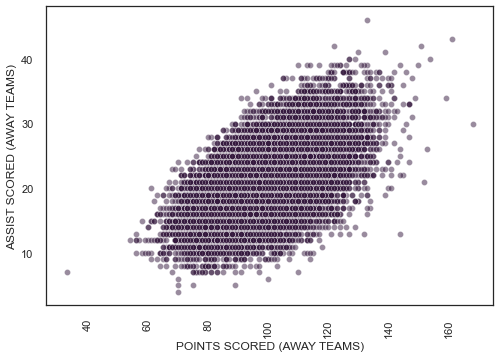

In [16]:
# here we wanted. to created a scatterplot to see the relationship between points scored and assists for either team
sns.scatterplot(x="PTS_home",y="AST_home",data=games,alpha=0.5)

plt.xlabel("POINTS SCORED (HOME TEAMS)")
plt.xticks(rotation = 90)
plt.ylabel("ASSIST SCORED (HOME TEAMS)")

plt.show()

sns.scatterplot(x="PTS_away",y="AST_away",data=games,alpha=0.5)

plt.xlabel("POINTS SCORED (AWAY TEAMS)")
plt.xticks(rotation = 90)
plt.ylabel("ASSIST SCORED (AWAY TEAMS)")
plt.title

plt.show()


## Section 2: Data Cleaning

In [17]:
ranking.set_index("STANDINGSDATE",inplace=True)
games = pd.merge_asof(games, ranking.add_suffix("_homeTeam"), left_index=True, right_index=True, left_by="HOME_TEAM_ID", right_by='TEAM_ID'+"_homeTeam", allow_exact_matches=False)
# suffixes="_homeTeam",  ## for some reason this gives error, so we workaround it by adding suffixes
games = pd.merge_asof(games, ranking.add_suffix("_awayTeam"),left_index=True, right_index=True, left_by="VISITOR_TEAM_ID", right_by='TEAM_ID'+"_awayTeam", allow_exact_matches=False)
games.drop(["SEASON_ID_awayTeam","TEAM_ID_awayTeam","TEAM_ID_homeTeam"],axis=1,inplace=True) ## redundant
games.rename(columns={"SEASON_ID_homeTeam":"SEASON_ID"},inplace=True)
print(games.shape)

(23520, 41)


In [18]:
# merged rankings and games so that they are all in one dataset. we indexed them on the game date.
games

,GAME_ID,GAME_STATUS_TEXT,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS,LEAGUE_ID_homeTeam,SEASON_ID,CONFERENCE_homeTeam,TEAM_homeTeam,G_homeTeam,W_homeTeam,L_homeTeam,W_PCT_homeTeam,HOME_RECORD_homeTeam,ROAD_RECORD_homeTeam,RETURNTOPLAY_homeTeam,LEAGUE_ID_awayTeam,CONFERENCE_awayTeam,TEAM_awayTeam,G_awayTeam,W_awayTeam,L_awayTeam,W_PCT_awayTeam,HOME_RECORD_awayTeam,ROAD_RECORD_awayTeam,RETURNTOPLAY_awayTeam
GAME_DATE_EST,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2003-10-05,10300001,Final,1610612762,1610612742,2003,1610612762,90.0,0.457,0.735,0.143,23.0,41.0,1610612742,85.0,0.447,0.500,0.250,20.0,38.0,1,0,22002,West,Utah,82,47,35,0.573,29-12,18-23,NaN,0,West,Dallas,82,60,22,0.732,33-8,27-14,NaN
2003-10-06,10300002,Final,1610612763,1610612749,2003,1610612763,105.0,0.494,0.618,0.267,25.0,48.0,1610612749,94.0,0.427,0.700,0.154,20.0,43.0,1,0,12003,West,Memphis,0,0,0,0.000,0-0,0-0,NaN,0,East,Milwaukee,0,0,0,0.000,0-0,0-0,NaN
2003-10-07,10300009,Final,1610612758,1610612746,2003,1610612758,101.0,0.467,0.871,0.444,19.0,39.0,1610612746,82.0,0.368,0.609,0.364,13.0,50.0,1,0,12003,West,Sacramento,0,0,0,0.000,0-0,0-0,NaN,0,West,L.A. Clippers,0,0,0,0.000,0-0,0-0,NaN
2003-10-07,10300005,Final,1610612757,1610612745,2003,1610612757,104.0,0.527,0.657,0.429,22.0,33.0,1610612745,80.0,0.470,0.667,0.333,10.0,37.0,1,0,12003,West,Portland,0,0,0,0.000,0-0,0-0,NaN,0,West,Houston,0,0,0,0.000,0-0,0-0,NaN
2003-10-07,10300007,Final,1610612748,1610612755,2003,1610612748,86.0,0.352,0.647,0.222,15.0,55.0,1610612755,79.0,0.329,0.897,0.143,7.0,44.0,1,0,12003,East,Miami,0,0,0,0.000,0-0,0-0,NaN,0,East,Philadelphia,0,0,0,0.000,0-0,0-0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-18,12000040,Final,1610612761,1610612748,2020,1610612761,105.0,0.380,0.737,0.356,27.0,37.0,1610612748,117.0,0.534,0.741,0.514,30.0,51.0,0,0,12020,East,Toronto,2,2,0,1.000,0-0,2-0,NaN,0,East,Miami,1,0,1,0.000,0-1,0-0,NaN
2020-12-18,12000039,Final,1610612754,1610612755,2020,1610612754,107.0,0.371,0.692,0.262,19.0,45.0,1610612755,113.0,0.533,0.629,0.355,23.0,48.0,0,0,12020,East,Indiana,2,0,2,0.000,0-0,0-2,NaN,0,East,Philadelphia,1,1,0,1.000,1-0,0-0,NaN
2020-12-19,12000049,Final,1610612763,1610612737,2020,1610612763,116.0,0.400,0.744,0.396,21.0,43.0,1610612737,117.0,0.422,0.837,0.297,24.0,47.0,0,0,12020,West,Memphis,3,3,0,1.000,1-0,2-0,NaN,0,East,Atlanta,3,1,2,0.333,1-1,0-1,NaN


In [19]:
games.drop(columns = ['HOME_TEAM_ID', 'VISITOR_TEAM_ID','GAME_STATUS_TEXT','TEAM_ID_home', 'TEAM_ID_away', 'LEAGUE_ID_homeTeam', 'SEASON_ID','RETURNTOPLAY_homeTeam', 'RETURNTOPLAY_awayTeam', 'LEAGUE_ID_awayTeam'], inplace = True)

In [20]:
# putting win percentage at .500 when a team has not played a game yet
def win_percent(row):
    if row['G_homeTeam'] ==0:
        row['W_PCT_homeTeam'] = .500
    if row['G_awayTeam'] ==0:
        row['W_PCT_awayTeam'] = .500
    return row
games = games.apply(win_percent, axis = 1)

In [21]:
games.dropna(inplace = True)

In [22]:
games

,GAME_ID,SEASON,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS,CONFERENCE_homeTeam,TEAM_homeTeam,G_homeTeam,W_homeTeam,L_homeTeam,W_PCT_homeTeam,HOME_RECORD_homeTeam,ROAD_RECORD_homeTeam,CONFERENCE_awayTeam,TEAM_awayTeam,G_awayTeam,W_awayTeam,L_awayTeam,W_PCT_awayTeam,HOME_RECORD_awayTeam,ROAD_RECORD_awayTeam
GAME_DATE_EST,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2003-10-05,10300001,2003,90.0,0.457,0.735,0.143,23.0,41.0,85.0,0.447,0.500,0.250,20.0,38.0,1,West,Utah,82,47,35,0.573,29-12,18-23,West,Dallas,82,60,22,0.732,33-8,27-14
2003-10-06,10300002,2003,105.0,0.494,0.618,0.267,25.0,48.0,94.0,0.427,0.700,0.154,20.0,43.0,1,West,Memphis,0,0,0,0.500,0-0,0-0,East,Milwaukee,0,0,0,0.500,0-0,0-0
2003-10-07,10300009,2003,101.0,0.467,0.871,0.444,19.0,39.0,82.0,0.368,0.609,0.364,13.0,50.0,1,West,Sacramento,0,0,0,0.500,0-0,0-0,West,L.A. Clippers,0,0,0,0.500,0-0,0-0
2003-10-07,10300005,2003,104.0,0.527,0.657,0.429,22.0,33.0,80.0,0.470,0.667,0.333,10.0,37.0,1,West,Portland,0,0,0,0.500,0-0,0-0,West,Houston,0,0,0,0.500,0-0,0-0
2003-10-07,10300007,2003,86.0,0.352,0.647,0.222,15.0,55.0,79.0,0.329,0.897,0.143,7.0,44.0,1,East,Miami,0,0,0,0.500,0-0,0-0,East,Philadelphia,0,0,0,0.500,0-0,0-0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-18,12000040,2020,105.0,0.380,0.737,0.356,27.0,37.0,117.0,0.534,0.741,0.514,30.0,51.0,0,East,Toronto,2,2,0,1.000,0-0,2-0,East,Miami,1,0,1,0.000,0-1,0-0
2020-12-18,12000039,2020,107.0,0.371,0.692,0.262,19.0,45.0,113.0,0.533,0.629,0.355,23.0,48.0,0,East,Indiana,2,0,2,0.000,0-0,0-2,East,Philadelphia,1,1,0,1.000,1-0,0-0
2020-12-19,12000049,2020,116.0,0.400,0.744,0.396,21.0,43.0,117.0,0.422,0.837,0.297,24.0,47.0,0,West,Memphis,3,3,0,1.000,1-0,2-0,East,Atlanta,3,1,2,0.333,1-1,0-1


In [23]:
def win_percent(row):
    if row['G_homeTeam'] ==0:
        row['W_PCT_homeTeam'] = .500
    if row['G_awayTeam'] ==0:
        row['W_PCT_awayTeam'] = .500
    return row
games = games.apply(win_percent, axis = 1)

In [24]:
games

,GAME_ID,SEASON,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS,CONFERENCE_homeTeam,TEAM_homeTeam,G_homeTeam,W_homeTeam,L_homeTeam,W_PCT_homeTeam,HOME_RECORD_homeTeam,ROAD_RECORD_homeTeam,CONFERENCE_awayTeam,TEAM_awayTeam,G_awayTeam,W_awayTeam,L_awayTeam,W_PCT_awayTeam,HOME_RECORD_awayTeam,ROAD_RECORD_awayTeam
GAME_DATE_EST,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2003-10-05,10300001,2003,90.0,0.457,0.735,0.143,23.0,41.0,85.0,0.447,0.500,0.250,20.0,38.0,1,West,Utah,82,47,35,0.573,29-12,18-23,West,Dallas,82,60,22,0.732,33-8,27-14
2003-10-06,10300002,2003,105.0,0.494,0.618,0.267,25.0,48.0,94.0,0.427,0.700,0.154,20.0,43.0,1,West,Memphis,0,0,0,0.500,0-0,0-0,East,Milwaukee,0,0,0,0.500,0-0,0-0
2003-10-07,10300009,2003,101.0,0.467,0.871,0.444,19.0,39.0,82.0,0.368,0.609,0.364,13.0,50.0,1,West,Sacramento,0,0,0,0.500,0-0,0-0,West,L.A. Clippers,0,0,0,0.500,0-0,0-0
2003-10-07,10300005,2003,104.0,0.527,0.657,0.429,22.0,33.0,80.0,0.470,0.667,0.333,10.0,37.0,1,West,Portland,0,0,0,0.500,0-0,0-0,West,Houston,0,0,0,0.500,0-0,0-0
2003-10-07,10300007,2003,86.0,0.352,0.647,0.222,15.0,55.0,79.0,0.329,0.897,0.143,7.0,44.0,1,East,Miami,0,0,0,0.500,0-0,0-0,East,Philadelphia,0,0,0,0.500,0-0,0-0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-18,12000040,2020,105.0,0.380,0.737,0.356,27.0,37.0,117.0,0.534,0.741,0.514,30.0,51.0,0,East,Toronto,2,2,0,1.000,0-0,2-0,East,Miami,1,0,1,0.000,0-1,0-0
2020-12-18,12000039,2020,107.0,0.371,0.692,0.262,19.0,45.0,113.0,0.533,0.629,0.355,23.0,48.0,0,East,Indiana,2,0,2,0.000,0-0,0-2,East,Philadelphia,1,1,0,1.000,1-0,0-0
2020-12-19,12000049,2020,116.0,0.400,0.744,0.396,21.0,43.0,117.0,0.422,0.837,0.297,24.0,47.0,0,West,Memphis,3,3,0,1.000,1-0,2-0,East,Atlanta,3,1,2,0.333,1-1,0-1


## Section 3: Feature Engineering

In [ ]:
teams = games.TEAM_homeTeam.unique()

In [ ]:
teams

In [ ]:
games.columns

In [ ]:
stats = ['PTS', 'FG_PCT', 'FT_PCT',
       'FG3_PCT', 'AST', 'REB']

In [ ]:
for stat in stats:
    print(stat+'_home')

In [ ]:
for stat in stats:
    for team in teams:
        x = games.loc[(games.TEAM_homeTeam == team) | (games.TEAM_awayTeam == team), :]
        rolling = pd.Series(np.where(x.TEAM_homeTeam == team, x[stat+'_home'], x[stat+'_away'])).rolling(10).mean()
        rolling.index = x.index
        trues = x.TEAM_homeTeam == team
        games.loc[games.TEAM_homeTeam == team, stat+'_rolling_home'] = rolling[trues]
        games.loc[games.TEAM_awayTeam == team, stat+'_rolling_away'] = rolling[~trues]

In [ ]:
games.HOME_RECORD_awayTeam.isna().sum()

In [ ]:
games['HOME_RECORD_homeTeam'] = games.HOME_RECORD_homeTeam.str.split('-')
games['home_wins_home_team'] = games.HOME_RECORD_homeTeam.apply(lambda x:int(x[0]))
games['home_losses_home_team'] = games.HOME_RECORD_homeTeam.apply(lambda x:int(x[1]))

In [ ]:
games['ROAD_RECORD_homeTeam'] = games.ROAD_RECORD_homeTeam.str.split('-')
games['road_wins_home_team'] = games.ROAD_RECORD_homeTeam.apply(lambda x:int(x[0]))
games['road_losses_home_team'] = games.ROAD_RECORD_homeTeam.apply(lambda x:int(x[1]))

In [ ]:
games['HOME_RECORD_awayTeam'] = games.HOME_RECORD_awayTeam.str.split('-')
games['home_wins_away_team'] = games.HOME_RECORD_awayTeam.apply(lambda x:int(x[0]))
games['home_losses_away_team'] = games.HOME_RECORD_awayTeam.apply(lambda x:int(x[1]))

In [ ]:
games['ROAD_RECORD_awayTeam'] = games.ROAD_RECORD_awayTeam.str.split('-')
games['road_wins_away_team'] = games.ROAD_RECORD_awayTeam.apply(lambda x:int(x[0]))
games['road_losses_away_team'] = games.ROAD_RECORD_awayTeam.apply(lambda x:int(x[1]))

In [ ]:
conditions = [(games.home_wins_home_team == 0) & (games.home_losses_home_team == 0), (games.home_wins_home_team > 0) & (games.home_losses_home_team == 0)]
values = [0.5, 1.0]
games['home_team_home_win_pct'] = np.select(conditions, values, default = games.home_wins_home_team/(games.home_wins_home_team+games.home_losses_home_team))

In [ ]:
games['home_team_home_win_pct']

In [ ]:
conditions = [(games.road_wins_home_team == 0) & (games.road_losses_home_team == 0), (games.road_wins_home_team > 0) & (games.road_losses_home_team == 0)]
values = [0.5, 1.0]
games['home_team_away_win_pct'] = np.select(conditions, values, default = games.road_wins_home_team/(games.road_wins_home_team+games.road_losses_home_team))

In [ ]:
conditions = [(games.home_wins_away_team == 0) & (games.home_losses_away_team == 0), (games.home_wins_away_team > 0) & (games.home_losses_away_team == 0)]
values = [0.5, 1.0]
games['away_team_home_win_pct'] = np.select(conditions, values, default = games.home_wins_away_team/(games.home_wins_away_team+games.home_losses_away_team))

In [ ]:
conditions = [(games.road_wins_away_team == 0) & (games.road_losses_away_team == 0), (games.road_wins_away_team > 0) & (games.road_losses_away_team == 0)]
values = [0.5, 1.0]
games['away_team_away_win_pct'] = np.select(conditions, values, default = games.road_wins_away_team/(games.road_wins_away_team+games.road_losses_away_team))

In [ ]:
games.columns=[x.lower() for x in games.columns]

In [ ]:
games.isna().sum()

### Dropping null values due to no rolling statistics, as well as null values being only in preseason games

In [ ]:
games.dropna(inplace=True)

In [ ]:
games

In [ ]:
# feature engineered data to show how much the home team won or loss by. this would be a perfect depedent variable for a continuous regression model
games['pts_diff'] = games['pts_home'] - games['pts_away']

In [ ]:
# team disparity was used to look at games where one team is much better (i.e. has a much better record) or much worse than another team
games['team_disparity'] = games.w_pct_hometeam - games.w_pct_awayteam

In [ ]:
# here, we obtained dummies for each team (away and home)
games = pd.get_dummies(games, prefix=['H', 'A'], columns=['team_hometeam', 'team_awayteam'])

In [ ]:
# this shows you what some of our dummies look like
games.iloc[:, 70:121]

In [ ]:
# created a function to plot a confusion matrix
def plot_confusion_matrix(
    cm,
    classes,
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.Blues
):
    '''
    Function that prints and plots a model's confusion matrix.
    Input
    -----
    cm : sklearn confusion matrix
        `sklearn.metrics.confusion_matrix(y_true, y_pred)`

    classes : list (str)
        Names of target classes.
    Optional input
    --------------
    normalize : bool
        Whether to apply normalization (default=False).
        Normalization can be applied by setting `normalize=True`.
    title : str
        Title of the returned plot.
    cmap : matplotlib color map
        For options, visit:
        `https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html`
    Output
    ------
    Prints a stylized confusion matrix.
    '''
    # convert to percentage, if normalize set to True
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    # plot
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    # format true positives and others
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize=16,
                 horizontalalignment="center", verticalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    # add axes labels
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [ ]:
# make the confusion matrix better to visualize
sns.set(style="white")
sns.set_context('poster')

### Section 4: Modeling

In [ ]:
# first, we need to set aside the features we will be using
games.columns.unique()
print(games.columns.tolist())
games.dropna(inplace=True)

In [ ]:
games.isna().sum().sum()

In [ ]:
# here are the most important features we would like to be using in our model.
# we took out anything we did not feature engineer ourselves and made it a completely predicitive nodel by only taking stats of teams before a given game (not stats of the given game)
features = ['season','w_pct_hometeam','w_pct_awayteam', 'pts_rolling_home', 'pts_rolling_away', 'fg_pct_rolling_home',
            'fg_pct_rolling_away', 'ft_pct_rolling_home', 'ft_pct_rolling_away',
            'fg3_pct_rolling_home', 'fg3_pct_rolling_away', 'ast_rolling_home',
            'ast_rolling_away', 'reb_rolling_home', 'reb_rolling_away',  'home_team_home_win_pct',
            'away_team_away_win_pct', 'team_disparity', 
            'H_Atlanta', 'H_Boston', 'H_Brooklyn', 'H_Charlotte', 
            'H_Chicago', 'H_Cleveland', 'H_Dallas', 'H_Denver', 'H_Detroit', 'H_Golden State', 'H_Houston', 'H_Indiana', 'H_L.A. Clippers', 
            'H_L.A. Lakers', 'H_LA Clippers', 'H_Memphis', 'H_Miami', 'H_Milwaukee', 'H_Minnesota', 'H_New Jersey', 'H_New Orleans', 
            'H_New Orleans/Oklahoma City', 'H_New York', 'H_Oklahoma City', 'H_Orlando', 'H_Philadelphia', 'H_Phoenix', 'H_Portland', 
            'H_Sacramento', 'H_San Antonio', 'H_Seattle', 'H_Toronto', 'H_Utah', 'H_Washington', 'A_Atlanta', 'A_Boston', 'A_Brooklyn', 
            'A_Charlotte', 'A_Chicago', 'A_Cleveland', 'A_Dallas', 'A_Denver', 'A_Detroit', 'A_Golden State', 'A_Houston', 'A_Indiana', 
            'A_L.A. Clippers', 'A_L.A. Lakers', 'A_LA Clippers', 'A_Memphis', 'A_Miami', 'A_Milwaukee', 'A_Minnesota', 'A_New Jersey', 
            'A_New Orleans', 'A_New Orleans/Oklahoma City', 'A_New York', 'A_Oklahoma City', 'A_Orlando', 'A_Philadelphia', 'A_Phoenix', 
            'A_Portland', 'A_Sacramento', 'A_San Antonio', 'A_Seattle', 'A_Toronto', 'A_Utah', 'A_Washington']

In [ ]:
# see which variables are correlated with one another. threshold is 0.8. anything above will be taken out
corr_matrix = games[features].corr().abs()

# the matrix is symmetric so we need to extract upper triangle matrix without diagonal (k = 1)

sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool)) 
                  .stack()
                  .sort_values(ascending=False))

print(sol)
corr_matrix

In [ ]:
# this would ber dependent variable for regression model
pts_diff = games['pts_diff']

In [ ]:
# this is our dependent variable for binary classification model
win_loss = games['home_team_wins']

In [ ]:
# calculating baseline 
games.home_team_wins.value_counts()
13727/(13727+9393)

#### Logistic Regression

In [ ]:
# we are splitting our training and testing data - 80% of our data will be in the training set, 20% will be in our test set
X_train, X_test, y_train, y_test = train_test_split(games[features], win_loss, test_size = 0.2, random_state = 1) 

# resampling our data on the minority class (oversampling) because of the disparity between each class (home team had more wins, which is logical)
sm = SMOTE(sampling_strategy = 'minority', random_state = 123)
X_train, y_train = sm.fit_resample(X_train, y_train)

print(pd.Series(y_train).value_counts())

In [ ]:
# setting logreg equal to our logistic regression function
logreg =LogisticRegression()
# fitting our data onto our model
logreg.fit(X_train, y_train)
# using our model to predict our y values with our test set data
y_pred_class = logreg.predict(X_test)
y_pred_train = logreg.predict(X_train)
# predict probabilities for our testing target variable using our model
logreg.predict_proba(X_test)

In [ ]:
# creating a dictionary to show our coefficents for each independent variable
dictionary=dict(zip(list(X_train.columns), list(logreg.coef_[0])))
dictionary

In [ ]:
# checking accuracy
print('Test Accuracy score: ', metrics.accuracy_score(y_test, y_pred_class))
print('Train Accuracy score: ', metrics.accuracy_score(y_train, y_pred_train))
# checking precision
print('Test Precision score: ', metrics.precision_score(y_test, y_pred_class))
print('Train Precision score: ', metrics.precision_score(y_train, y_pred_train))
# checking Recall (Sensitivity)
print('Test Recall (Sensitivity) score: ', metrics.recall_score(y_test, y_pred_class))
print('Train Recall (Sensitivity) score: ', metrics.recall_score(y_train, y_pred_train))
# checking F1 score
print('Test F1 score: ', metrics.f1_score(y_test, y_pred_class))
print('Train F1 score: ', metrics.f1_score(y_train, y_pred_train))

In [ ]:
# created a confusion matrix for our testing data using our logistic model from above
cm = confusion_matrix(y_test, y_pred_class)
# used our function for plotting our confusion matrix
plot_confusion_matrix(
    cm,
     ['loss', 'win'],
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.Blues
)

In [ ]:
# created a confusion matrix for our testing data using our logistic model from above
cm = confusion_matrix(y_test, y_pred_class)
# used our function for plotting our confusion matrix
plot_confusion_matrix(
    cm,
    ['loss', 'win'],
    normalize=True,
    title='Confusion matrix',
    cmap=plt.cm.Blues
)

#### ROC Curve

In [ ]:
y_pred_proba = logreg.predict_proba(X_test)

In [ ]:
y_test.value_counts()

In [ ]:
y_test.shape

In [ ]:
y_pred_proba.shape

In [ ]:
# store the predicted probabilities for class 1
y_pred_prob = logreg.predict_proba(X_test)[:, 1]
y_pred_prob

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve')
plt.xlabel('False Positive Rate (1-Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

fpr, tpr, thresholds

In [ ]:
def evaluate_threshold(threshold):
    print('Sensitivity: ' , tpr[thresholds>threshold][-1])
    print('Specificity: ' , 1-fpr[thresholds>threshold][-1])

In [ ]:
evaluate_threshold(.5)
print(metrics.roc_auc_score(y_test, y_pred_prob))

### KNN Classifier

In [ ]:
# scaled X_train and X_test to make variables similary scaled and centered
scaler = StandardScaler()
scaler.fit(X_train) 
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# creating our KNN classifier and setting it equal to knn with n_neighbors equals 1. We wanted this to be as precise as possible
# so we wanted it based on one neighbor
knn = KNeighborsClassifier(n_neighbors=61, n_jobs=-1)
# fitting our training data into our knn model
knn.fit(X_train, y_train)
# predicting our dependet variable using our model and test data
knn_preds = knn.predict(X_test)
knn_preds_train = knn.predict(X_train)

In [ ]:
# checking accuracy of test and train
print('Test Accuracy score: ', metrics.accuracy_score(y_test, knn_preds))
print('Train Accuracy score: ', metrics.accuracy_score(y_train, knn_preds_train))
# checking precision of test and train
print('Test Precision score: ', metrics.precision_score(y_test, knn_preds))
print('Train Precision score: ', metrics.precision_score(y_train, knn_preds_train))
# checking Recall (Sensitivity) of test and train
print('Test Recall (Sensitivity) score: ', metrics.recall_score(y_test,knn_preds))
print('Train Recall (Sensitivity) score: ', metrics.recall_score(y_train, knn_preds_train))
# checking F1 score of test and train
print('Test F1 score: ', metrics.f1_score(y_test, knn_preds))
print('Train F1 score: ', metrics.f1_score(y_train, knn_preds_train))

In [ ]:
# created a confusion matrix for our testing data using our logistic model from above
cm = confusion_matrix(y_test, knn_preds)
# used our function for plotting our confusion matrix
plot_confusion_matrix(
    cm,
    ['functional', 'non-functional'],
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.Blues
)

In [ ]:
# created a confusion matrix for our testing data using our logistic model from above
cm = confusion_matrix(y_test, knn_preds)
# used our function for plotting our confusion matrix
plot_confusion_matrix(
    cm,
    ['functional', 'non-functional'],
    normalize=True,
    title='Confusion matrix',
    cmap=plt.cm.Blues
)

In [ ]:
# search for an optimal value of K for KNN
k_range = list(range(1, 11))
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    knn.fit(X_train, y_train)
    y_predict = knn.predict(X_test)
    score = metrics.accuracy_score(y_test, y_predict) # can replace accuracy with precision, recall
    k_scores.append( score)
print(k_scores)

In [ ]:
import matplotlib.pyplot as plt  

plt.figure(figsize=(12, 6))  
plt.plot(range(1, 11), k_scores, color='red', linestyle='dashed', marker='o',  
         markerfacecolor='blue', markersize=10)
plt.title('Accuracy score by K Value')  
plt.xlabel('K Value')  
plt.ylabel('Accuracy Score') 
plt.show()

In [ ]:
# search for an optimal value of K for KNN
k_range = list(range(1, 61, 5))
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    knn.fit(X_train, y_train)
    y_predict = knn.predict(X_test)
    score = metrics.accuracy_score(y_test, y_predict) # can replace accuracy with precision, recall
    k_scores.append( score)
print(k_scores)

In [ ]:
import matplotlib.pyplot as plt  

plt.figure(figsize=(12, 6))  
plt.plot(range(1, 61, 5), k_scores, color='red', linestyle='dashed', marker='o',  
         markerfacecolor='blue', markersize=10)
plt.title('Accuracy score by K Value')  
plt.xlabel('K Value')  
plt.ylabel('Accuracy Score') 
plt.show()

### Decision Tree

In [ ]:
# rerunning our train test split at we had scaled it in KNN previously
X_train, X_test, y_train, y_test = train_test_split(games[features], win_loss, test_size = 0.2, random_state = 1) 
sm = SMOTE(sampling_strategy = 'minority', random_state = 123)
X_train, y_train = sm.fit_resample(X_train, y_train)
# training a DescisionTreeClassifier with unspecified max depth
dtree_model = DecisionTreeClassifier().fit(X_train, y_train) 
# calculating our predictions for our model using our test data
dtree_predictions = dtree_model.predict(X_test) 
dtree_predictions_train = dtree_model.predict(X_train)

In [ ]:
# checking accuracy of test and train
print('Test Accuracy score: ', metrics.accuracy_score(y_test, dtree_predictions))
print('Train Accuracy score: ', metrics.accuracy_score(y_train, dtree_predictions_train))
# checking precision of test and train
print('Test Precision score: ', metrics.precision_score(y_test, dtree_predictions))
print('Train Precision score: ', metrics.precision_score(y_train, dtree_predictions_train))
# checking Recall (Sensitivity) of test and train
print('Test Recall (Sensitivity) score: ', metrics.recall_score(y_test, dtree_predictions))
print('Train Recall (Sensitivity) score: ', metrics.recall_score(y_train, dtree_predictions_train))
# checking F1 score of test and train
print('Test F1 score: ', metrics.f1_score(y_test, dtree_predictions))
print('Train F1 score: ', metrics.f1_score(y_train, dtree_predictions_train))

In [ ]:
# created a confusion matrix for our testing data using our logistic model from above
cm = confusion_matrix(y_test, dtree_predictions)
# used our function for plotting our confusion matrix
plot_confusion_matrix(
    cm,
    ['functional', 'non-functional'],
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.Blues
)

In [ ]:
# created a confusion matrix for our testing data using our logistic model from above
cm = confusion_matrix(y_test, dtree_predictions)
# used our function for plotting our confusion matrix
plot_confusion_matrix(
    cm,
    ['functional', 'non-functional'],
    normalize=True,
    title='Confusion matrix',
    cmap=plt.cm.Blues
)

In [ ]:
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None,6, 10, 15],
    'min_samples_split': [2, 3, 4, 5],
    'min_samples_leaf': [30, 40, 50]
}

# instantiate GridSearchCV. Specifying that we are looking to return our highest recall score.
dt_grid_search = GridSearchCV(dtree_model, dt_param_grid, cv=5, scoring='accuracy', return_train_score=True, verbose = 1, n_jobs=-1)
# fit to the data
dt_grid_search.fit(X_train, y_train)

In [ ]:
# Mean training score
dt_gs_training_score = np.mean(dt_grid_search.cv_results_['mean_train_score'])
# Mean test score
dt_gs_testing_score = dt_grid_search.score(X_test, y_test)
print(f"Mean Training Score: {dt_gs_training_score :.2%}")
print(f"Mean Test Score: {dt_gs_testing_score :.2%}")
print("Best Parameter Combination Found During Grid Search:")
dt_grid_search.best_params_

#### We ran our first model using max_depth None to see how it would fair. That model was highly overfitted. We then used grid search to see if we could find a max depth that may be more optimal and less over fitting. Recommended max_depth was 6 with an overal test score accuracy of roughly 65%. We will evaluate other models to compare to decision tree results.

### Random Forest Classifier

In [ ]:
# create a Random Forest Classifier, with our random state equaling 42
clf=RandomForestClassifier(max_depth = None, min_samples_leaf = 1, min_samples_split = 2, random_state = 42, n_jobs=-1)
# train the model using the training sets y_pred=clf.predict(X_test)
jungle_model = clf.fit(X_train,y_train)
# predicitng our dependent variable using our model and the test data for our independent variable
y_pred=jungle_model.predict(X_test)
y_pred_train=jungle_model.predict(X_train)

In [ ]:
# checking accuracy of test and train
print('Test Accuracy score: ', metrics.accuracy_score(y_test, y_pred))
print('Train Accuracy score: ', metrics.accuracy_score(y_train, y_pred_train))
# checking precision of test and train
print('Test Precision score: ', metrics.precision_score(y_test, y_pred))
print('Train Precision score: ', metrics.precision_score(y_train, y_pred_train))
# checking Recall (Sensitivity) of test and train
print('Test Recall (Sensitivity) score: ', metrics.recall_score(y_test, y_pred))
print('Train Recall (Sensitivity) score: ', metrics.recall_score(y_train, y_pred_train))
# checking F1 score of test and train
print('Test F1 score: ', metrics.f1_score(y_test, y_pred))
print('Train F1 score: ', metrics.f1_score(y_train, y_pred_train))

In [ ]:
# created a confusion matrix for our testing data using our logistic model from above
cm = confusion_matrix(y_test, y_pred)
# used our function for plotting our confusion matrix
plot_confusion_matrix(
    cm,
    ['loss', 'win'],
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.Blues
)

In [ ]:
# created a confusion matrix for our testing data using our logistic model from above
cm = confusion_matrix(y_test, y_pred)
# used our function for plotting our confusion matrix
plot_confusion_matrix(
    cm,
    ['loss', 'win'],
    normalize=True,
    title='Confusion matrix',
    cmap=plt.cm.Blues
)

In [ ]:
# create our parameters for grid search function
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [16, 20],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [60, 70] 
}
# Instantiate GridSearchCV
dt_grid_search = GridSearchCV(jungle_model, dt_param_grid, cv=5, scoring='accuracy', return_train_score=True, verbose = 1, n_jobs=-1)
# Fit to the data
dt_grid_search.fit(X_train, y_train)

In [ ]:
# mean training score
dt_gs_training_score = np.mean(dt_grid_search.cv_results_['mean_train_score'])
# mean test score
dt_gs_testing_score = dt_grid_search.score(X_test, y_test)
# printing each score out
print(f"Mean Training Score: {dt_gs_training_score :.2%}")
print(f"Mean Test Score: {dt_gs_testing_score :.2%}")
# printing our what our best parameters were given our criteria
print("Best Parameter Combination Found During Grid Search:")
dt_grid_search.best_params_

#### Random Forest gives us the highest accuracy score for any of our models. We ran our first model running our max_depth at None to see how it would fair. We realized quickly that this model would be very overfitting. We then used grid search to see if we could find a max depth that may be more optimal and less over fitting. We made our criteria based on maximizing our accuracy score as that was our most important metric. Grid search came back with a max_level of 16, which was great for our accuracy score and was not overfitting as we had a training score of 69.99% and a test score of 68.14%. Other parameters that we uses were what criterion to split on (gini or entropy), and our minimum sample split and samples leaf.

### Adaboost Model

In [ ]:
# create adaboost classifier model
adaboost_clf = AdaBoostClassifier()
# fit our model to training data set
adaboost_model = adaboost_clf.fit(X_train, y_train)

In [ ]:
# predict our dependent variable for our test set
adaboost_test_preds = adaboost_clf.predict(X_test)
# predict our depedent variable for our train set
adaboost_train_preds = adaboost_clf.predict(X_train)

In [ ]:
# checking accuracy of test and train
print('Test Accuracy score: ', metrics.accuracy_score(y_test, adaboost_test_preds))
print('Train Accuracy score: ', metrics.accuracy_score(y_train, adaboost_train_preds))
# checking precision of test and train
print('Test Precision score: ', metrics.precision_score(y_test, adaboost_test_preds))
print('Train Precision score: ', metrics.precision_score(y_train, adaboost_train_preds))
# checking Recall (Sensitivity) of test and train
print('Test Recall (Sensitivity) score: ', metrics.recall_score(y_test, adaboost_test_preds))
print('Train Recall (Sensitivity) score: ', metrics.recall_score(y_train, adaboost_train_preds))
# checking F1 score of test and train
print('Test F1 score: ', metrics.f1_score(y_test, adaboost_test_preds))
print('Train F1 score: ', metrics.f1_score(y_train, adaboost_train_preds))

In [ ]:
# created a confusion matrix for our testing data using our logistic model from above
cm = confusion_matrix(y_test, adaboost_test_preds)
# used our function for plotting our confusion matrix
plot_confusion_matrix(
    cm,
    ['loss', 'win'],
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.Blues
)

In [ ]:
# created a confusion matrix for our testing data using our logistic model from above
cm = confusion_matrix(y_test, adaboost_test_preds)
# used our function for plotting our confusion matrix
plot_confusion_matrix(
    cm,
    ['loss', 'win'],
    normalize=True,
    title='Confusion matrix',
    cmap=plt.cm.Blues
)

In [ ]:
# create our parameters for grid search function
dt_param_grid = {'n_estimators': [ 55, 60, 65]
}
# Instantiate GridSearchCV
dt_grid_search = GridSearchCV(adaboost_model, dt_param_grid, cv=5, scoring='accuracy', return_train_score=True, verbose = 1, n_jobs=-1)
# Fit to the data
dt_grid_search.fit(X_train, y_train)

In [ ]:
# mean training score
dt_gs_training_score = np.mean(dt_grid_search.cv_results_['mean_train_score'])
# mean test score
dt_gs_testing_score = dt_grid_search.score(X_test, y_test)
# printing each score out
print(f"Mean Training Score: {dt_gs_training_score :.2%}")
print(f"Mean Test Score: {dt_gs_testing_score :.2%}")
# printing our what our best parameters were given our criteria
print("Best Parameter Combination Found During Grid Search:")
dt_grid_search.best_params_

#### Our Adaboost model increased our accuracy from our baseline model and did not over fit on the test data. Without changing any parameters, are accuracy was already at 67.67%, higher than our logistic regression, decision tree, and random forest classifier.

### Gradient Boosting

In [ ]:
# creating gradient boost classifier and setting it equal to gbt_clf
gbt_clf = GradientBoostingClassifier()
# fitting our model using training data
gbt_model = gbt_clf.fit(X_train, y_train)

In [ ]:
# using our model to predict our testing data
gbt_clf_test_preds = gbt_clf.predict(X_test)
# using our model to predict our training data
gbt_clf_train_preds = gbt_clf.predict(X_train)

In [ ]:
# checking accuracy of test and train
print('Test Accuracy score: ', metrics.accuracy_score(y_test, gbt_clf_test_preds))
print('Train Accuracy score: ', metrics.accuracy_score(y_train, gbt_clf_train_preds))
# checking precision of test and train
print('Test Precision score: ', metrics.precision_score(y_test, gbt_clf_test_preds))
print('Train Precision score: ', metrics.precision_score(y_train, gbt_clf_train_preds))
# checking Recall (Sensitivity) of test and train
print('Test Recall (Sensitivity) score: ', metrics.recall_score(y_test, gbt_clf_test_preds))
print('Train Recall (Sensitivity) score: ', metrics.recall_score(y_train, gbt_clf_train_preds))
# checking F1 score of test and train
print('Test F1 score: ', metrics.f1_score(y_test, gbt_clf_test_preds))
print('Train F1 score: ', metrics.f1_score(y_train, gbt_clf_train_preds))

In [ ]:
# feature importance , gradient boosting, do not skip grid search

In [ ]:
# prepare at least three projects

In [ ]:
# do things you shouldve done

## Conclusion
Machine learning was extremely useful in helping us predict the outcome of NBA games, going from a 50% baseline score to an accuracy score of 66.5%. Not only did it help us predict which teams win, but gave us a better understanding of why teams win. Understanding basic statistics as well as engineering our own features helped us to get to this result.

## Next Steps
#### Grid Search
For each model, run a couple of more grid searches so that we can ensure we are using the best model and parameters for our given data set.
#### Regression Model
Implement a new model that predicts point differential (point spread) in a given game
#### Incorporate Player Data
Incorporating data from players of each given team to see if it will give us a better overall model and be more predicitive of NBA outcomes.

## Source
Alll data was initially sourced from basketball-reference.com and kaggle. Datasets were merged in order to have team stats and team rankings (win percentage, records, etc.) in the same dataset.